# Callbacks and Meta Scores

### Callbacks
A `callback` function is a user function that is called periodically by the optimizer in order to allow the user to query the state of the optimization.
For example, a simple user callback function might be used to plot results.
<!-- Missing: Add function to terminate or modify state of the optimization. -->
The function is called after each iteration for all best individuals at that state.

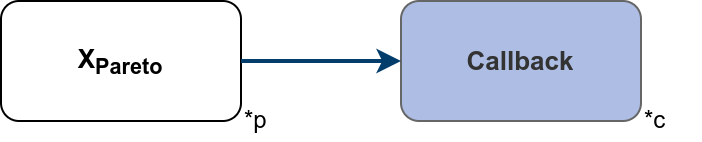
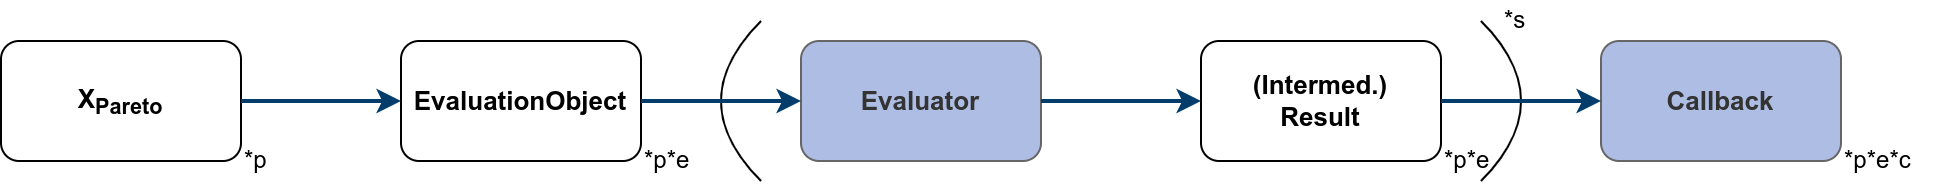

The callback signature may include any of the following arguments:
- results : obj
    x or final result of evaluation toolchain.
- individual : {class}`Individual`, optional
    Information about current step of optimzer.
- evaluation_object : obj, optional
    Current evaluation object.
- callbacks_dir : Path, optional
    Path to store results.

In [ ]:
# def callback(individual, evaluation_object, callbacks_dir):
#     print(individual.x, individual.f)
#     evaluation_object.plot(file_name=f'{callbacks_dir}/{individual.id}_{evaluation_object}_evaluation.png')

# def callback_fractionation(fractionation, individual, evaluation_object, callbacks_dir):
#     fractionation.plot_fraction_signal(0, end=0,
#         file_name=f'{callbacks_dir}/{individual.id}_{evaluation_object}_fractionation.png',
#         show=False
#     )
# ToDO: this cell was riddled with syntax errors and I don't know how it was supposed to be. I've tried to repair it best as I could

To add the function to the `OptimizationProblem`, use the `add_callback` method.
Analogous to objectives, 

In [ ]:
# optimization_problem.add_callback(
#     callback, requires=[process_simulator, frac_opt]
# )

```{figure} ./figures/callbacks_evaluator.svg
:name: callbacks_evaluator
```

### Multi-Objective
Often, multiple objectives are used. 

For example, in the case of a process optimization, where we might care about optimizing purity, performance, and cost. Or for a parameter estimation inverse-fitting approach, we might try to minimize the difference between the experimental data peak and the simulated peak with respect to both the peak position and the peak shape. 

These multi-objective optimization problems then lead to the existence of a Pareto-Front:

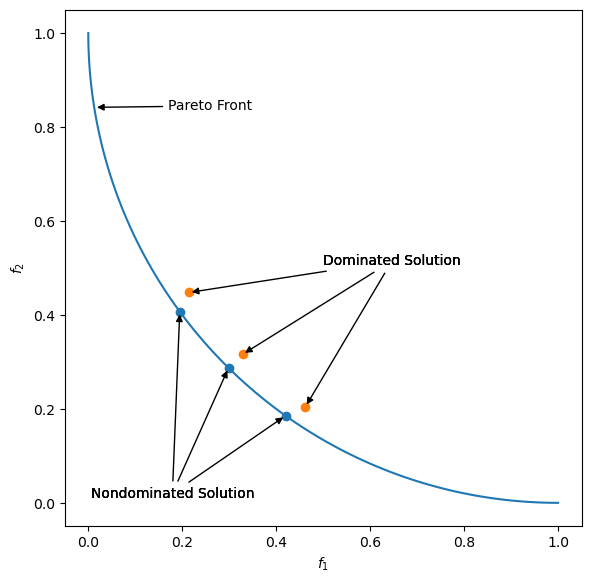

The definition of a Pareto-front is: "A Pareto-front is the set of all Pareto efficient solutions." As that isn't a very intuitive definition, consider this explanation:

If you have a trade-off between two (or more) objectives, the Pareto-front contains all the solutions to this trade-off where it is impossible to improve in one objective _without_ making another objective worse. Any solution to the trade-off with room for improvements are called "dominated solutions".

## Multiobjective Optimization example
Let's consider a simple Multiobjective example:

1 Optimization Variable

2 Objectives: simple quadratic functions which we both want to minimize


In [ ]:
def objective_1(x):
    return (x - 2) ** 2


def objective_2(x):
    return (x - 8) ** 2 + 10


Let's plot the objectives

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

x = np.arange(0, 11, 1)


def plot_objectives():
    fig, ax = plt.subplots(1)
    ax.plot(x, objective_1(x), label="Objective 1")
    ax.scatter([2], [0], marker="x", s=300)
    ax.text(1, 6, "Min. obj. 1", size=15)
    ax.plot(x, objective_2(x), label="Objective 2")
    ax.text(6.5, 3, "Min. obj. 2", size=15)
    ax.scatter([8], [10], marker="x", s=300)
    ax.vlines(x=[2, 8], ymin=0, ymax=ax.get_ylim()[1], colors="green", linestyles=":", label="Tradeoff region")
    rect = mpl.patches.Rectangle([2, 0], 6, 80, color="green", alpha=0.2)
    ax.add_patch(rect)
    ax.set_xlabel("Independent variable [-]")
    ax.set_ylabel("Objective performance [-]")
    ax.legend()


plot_objectives()

And plot possible solutions. To start, let's explore evenly spaced solutions between x = -1 and x = 11

In [ ]:
def plot_solutions(x):
    y1 = objective_1(x)
    y2 = objective_2(x)

    fig, ax = plt.subplots(1)
    ax.scatter(y1, y2)
    ax.set_xlabel("Objective 1 [-]")
    ax.set_ylabel("Objective 2 [-]")
    for point in x:
        ax.text(objective_1(point), objective_2(point), f"x = {point}", size=15)


plot_solutions(np.arange(-1, 12, 1))

We can see, that for the points between 2 and 8, no improvement in Objective 1 is possible without making Objective 2 worse. And vice versa. These points make up the pareto front. Points -1 to 1 and 9 to 11 are dominated by the pareto front.

In [ ]:
def plot_solutions_with_pareto(x):
    y1 = objective_1(x)
    y2 = objective_2(x)

    fig, ax = plt.subplots(1)
    ax.scatter(y1, y2)
    ax.set_xlabel("Objective 1 [-]")
    ax.set_ylabel("Objective 2 [-]")
    x_pareto = np.linspace(2, 8, 100)
    ax.plot(objective_1(x_pareto), objective_2(x_pareto), color="green", label="Pareto front")
    for point in x:
        ax.text(objective_1(point), objective_2(point), f"x = {point}", size=15)
    ax.vlines(objective_1(0), objective_2(0), objective_2(4), linestyles="--", linewidth=1, label="Dominated",
              colors="red")
    ax.hlines(objective_2(10), objective_1(10), objective_1(6), linestyles="--", linewidth=1, colors="red")
    ax.legend()


plot_solutions_with_pareto(np.arange(-1, 12, 1))

We can now optimize this problem in `CADETProcess`

In [ ]:
from CADETProcess.optimization import OptimizationProblem

optimization_problem = OptimizationProblem('multi_objective')
optimization_problem.add_variable('x', lb=0, ub=10)

Add the objectives we defined above:

In [ ]:
optimization_problem.add_objective(objective_1)
optimization_problem.add_objective(objective_2)

Alternatively, a single function that returns both objectives can be added. In this case, the number of objectives the function returns needs to be specified by adding `n_objectives` as argument.

In [ ]:
def multi_objective(x):
    f_1 = x[0] ** 2 + x[1] ** 2
    f_2 = (x[0] - 2) ** 2 + (x[1] - 2) ** 2
    return np.hstack((f_1, f_2))

# optimization_problem.add_objective(multi_objective, n_objectives=2)

In both cases, the total number of objectives is stored in `n_objectives`.

In [ ]:
optimization_problem.n_objectives

The objective(s) can be evaluated with the `evaluate_objectives()` method.

In [ ]:
optimization_problem.evaluate_objectives([1])

It is also possible to evaluate multiple sets of input variables at once by passing a 2D array to the `evaluate_objectives_population()` method.

In [ ]:
optimization_problem.evaluate_objectives_population([[2], [6], [8]])

And run a quick genetic algorithm to find the solutions.

In [ ]:
from CADETProcess.optimization import U_NSGA3

optimizer = U_NSGA3()
optimizer.n_max_gen = 5

optimization_results = optimizer.optimize(optimization_problem, log_level="WARNING")


In [ ]:
print(optimization_results.f)
print(optimization_results.x)
optimization_results.plot_convergence('objectives')

In [ ]:
fig, ax = plt.subplots()
ax.scatter(optimization_results.f[:, 0], optimization_results.f[:, 1], label="Solutions on the Pareto-front")
ax.legend()
# ToDo: Is there a built-in pareto plot?

### Multi-criteria decision making

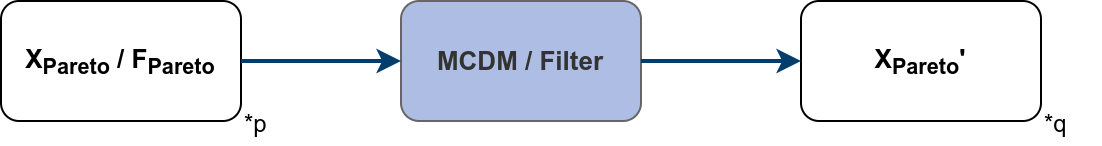

Multi-criteria decision functions can be used in multi-objective optimization to help decision-makers choose the best solution from a set of feasible solutions that meet the multiple objectives. MCDM methods typically involve a set of criteria that are used to evaluate the performance of each feasible solution, and then rank the solutions based on how well they perform across the criteria.

In multi-objective optimization, the goal is to find the set of solutions that are Pareto-optimal, meaning that there is no feasible solution that is better than any solution in the set across all objectives. Once a set of Pareto-optimal solutions has been identified, multi-criteria decision functions can be used to rank the solutions based on how well they perform across other criteria that are not explicitly included in the objective functions.

There are several MCDM methods that can be used in multi-objective optimization, including weighted sum, weighted product, and analytical hierarchy process (AHP). Weighted sum and weighted product are simple linear methods that involve assigning weights to each objective function and then summing or multiplying the weighted objectives to create a composite score for each feasible solution. AHP is a more complex method that involves comparing pairs of criteria and determining the relative importance of each criterion, and then using those weights to evaluate the performance of each feasible solution.

In general, the choice of MCDM method will depend on the specific problem and the preferences of the decision-makers involved. It is important to carefully consider the criteria that are important for the decision-making process and to choose a method that is appropriate for the problem at hand. Additionally, it is important to ensure that the resulting solution set is well-defined and that the chosen MCDM method produces results that are consistent with the goals of the optimization problem.

### Meta Scores

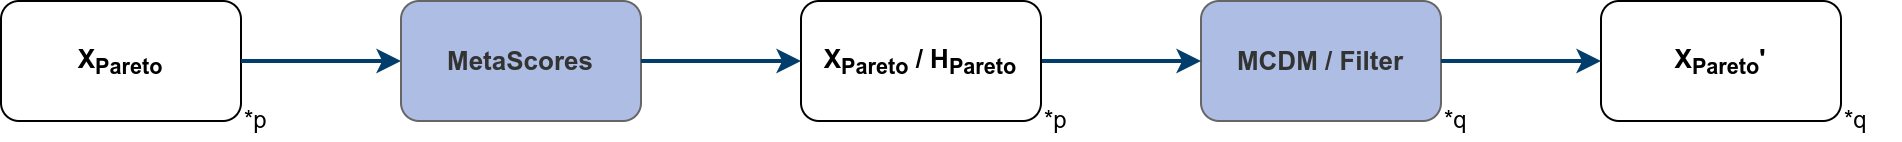


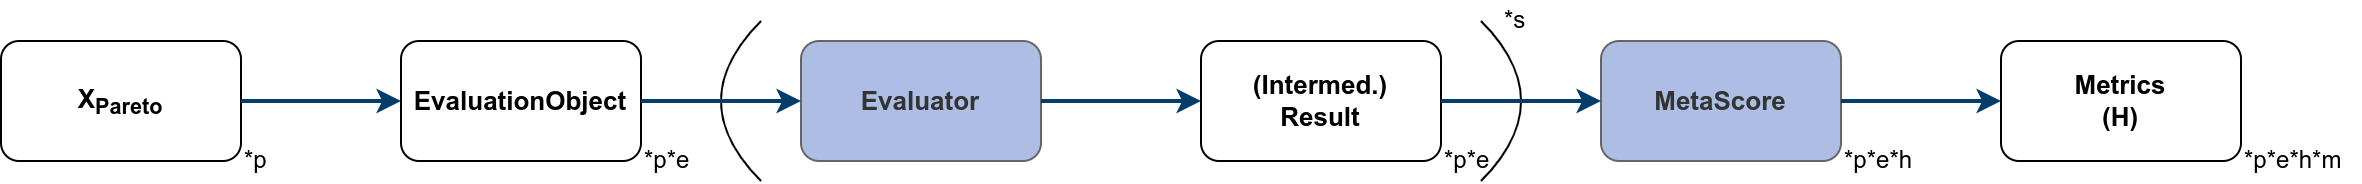